In [1]:
%load_ext autoreload
%autoreload 2
import lusee
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = [5, 3.5]
matplotlib.rcParams['figure.dpi'] = 100
from scipy.ndimage import gaussian_filter
from scipy.interpolate import interp1d
from scipy.integrate import simpson
import refspec
import os

In [2]:
# beam and frequency spacing
beam = lusee.Beam()
T=lusee.Throughput(beam)
f=np.logspace(-2,np.log10(52.),1000)

In [3]:
# sky signal
sky_frac_in = 1-beam.ground_fraction()
sky_frac_s = gaussian_filter(sky_frac_in,1)
sky_frac_s[0] = sky_frac_in[0]
sky_frac = interp1d(np.hstack((0,beam.freq)),np.hstack((0,sky_frac_s)),kind='quadratic', bounds_error=False, fill_value='extrapolate')
T_sky = lusee.monosky.T_C(f).value
T_ant = sky_frac(f)*T_sky + ((1-sky_frac(f))*200)

In [4]:
#plasma signa
P_plasma = np.zeros_like(f)
w = np.where((f>0.01)&(f<10))[0]
P_plasma[w] = lusee.monosky.BalePlasmaEffects()(f[w])

In [5]:
P_sky_jfet = T_ant * T.T2Vsq(f)
P_plasma_jfet  = P_plasma*T.Gamma_VD(f)**2
P_jfet = P_sky_jfet + P_plasma_jfet

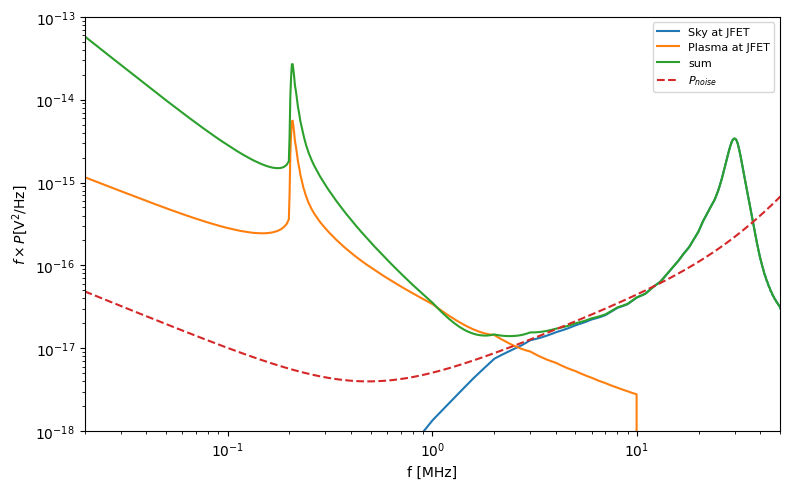

In [6]:
plt.figure(figsize=(8,5))
plt.plot(f,f*P_sky_jfet, label= 'Sky at JFET')
plt.plot(f,f*P_plasma_jfet, label= 'Plasma at JFET')
plt.plot(f,f*P_sky_jfet+P_plasma_jfet, label= 'sum')
plt.plot(f,f*T.noise(f),'--',label='$P_{noise}$')
plt.loglog()
plt.xlim(0.02,50)
plt.ylim(1e-18,1e-13)
plt.legend(fontsize=8)
plt.xlabel('f [MHz]')
plt.ylabel('$f \\times P [{\\rm V^2/Hz}]$')
plt.tight_layout()



In [7]:
gain = T.power_gain(f,'M')
noise = T.noise(f)
P_adc = (P_jfet+noise)*gain

In [8]:
def generate_samples (P, filename, Nsec=1, PF_amplitude=0.0, seed=10, bit_level=1/(2**13),bits=16):
    cfg = refspec.SpecConfig()
    sampling_rate = cfg.sampling_rate
    block_size = cfg.Nfft ## irrelevant here
    Nsamples = int(Nsec*sampling_rate)
    Nblocks = Nsamples//block_size+1
    Nchannels = 1
    print (sampling_rate, block_size, Nchannels, Nblocks+1, False, False, seed, True)
    raw_source = refspec.PowerSpecSource (f,P,sampling_rate, block_size, Nchannels, Nblocks+1, False, False, seed, True)
    if PF_amplitude>0:
        picket_fname = os.environ['REFSPEC_PATH']+'/data/samples/picket_fence_1024.txt'
        PF = refspec.CombSource(block_size, Nchannels, 1024, picket_fname, 1, PF_amplitude)
        source = refspec.SignalCombiner([raw_source, PF], True)
    else:
        source = raw_source

    sink = refspec.FileStreamSink (source, filename+'.bin', bit_level = bit_level, bits=bits);
    np.savetxt(filename+'_pk.txt',np.vstack((f,P)).T)
    sink.write_data(Nsamples)
    print (f"min: {sink.min_float()} max:{sink.max_float()} rms:{sink.rms()}  ")
    print (f"sample min: {sink.min_int()} sample max:{sink.max_int()}  rms:{sink.rms()/bit_level}  ")


def measure_pk (filename):
    cfg = refspec.SpecConfig()
    cfg.Ntaps           = 8
    cfg.Nchannels       = 1
    cfg.Average1Size    = 64
    cfg.Average2Size    = 700
    fundamental         = cfg.fundamental_frequency()
    blocks              = cfg.AverageSize()+2*cfg.Ntaps
    signal = refspec.FileStreamSource(cfg.Nfft,cfg.Nchannels,filename)
    output = refspec.SpecOutput(cfg)
    spectrometer = refspec.RefSpectrometer(signal, cfg)
    spectrometer.run(output)
    f = fundamental*np.arange(cfg.Nbins())/1e6
    Pk = np.array([output.get_avg_pspec(0, i) for i in range(0, cfg.Nbins())])
    return f, Pk

def make_plot (fm,Pm, f,P, bit_level):
    plt.figure(figsize=(10,5))
    plt.plot(fm,Pm*bit_level**2,label='measured')
    plt.plot(f,P,label='expected')
    plt.loglog()
    plt.xlabel('frequency [MHz]')
    plt.ylabel('power')
    plt.legend()

102400000.0 4096 1 50002 False False 10 True
*** Planning 204808192 samples = 2.00008 seconds. ***
*** Generating... ***
*** Seed: 10 ***
*** Transforming... ***
*** Done ***
min: -0.00035094708437100053 max:0.0003494609263725579 rms:4.6104672946967185e-05  
sample min: -23396 sample max:23297  rms:3073.644863131146  
Read 204800000 records from jfet_waveform.bin


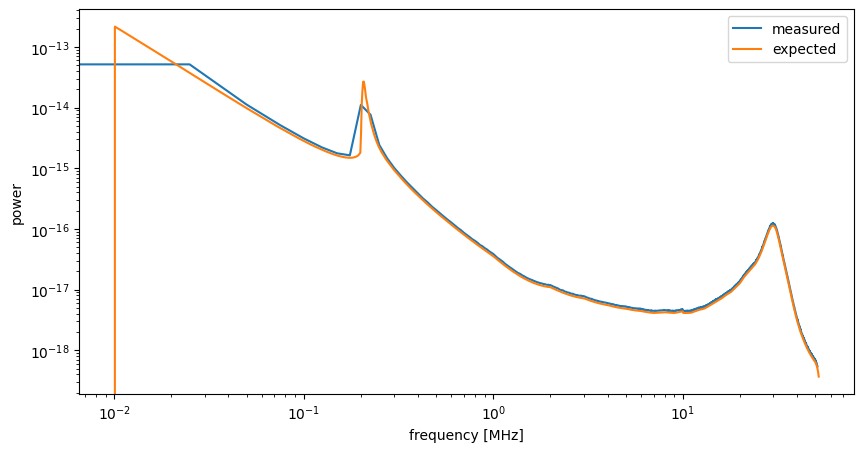

In [9]:
bit_level = 1.5e-8
generate_samples(P_jfet, "jfet_waveform", Nsec=2, bit_level=bit_level, bits=16)
fm, Pm = measure_pk("jfet_waveform.bin")
make_plot(fm,Pm, f,P_jfet, bit_level)



102400000.0 4096 1 50002 False False 10 True
*** Planning 204808192 samples = 2.00008 seconds. ***
*** Generating... ***
*** Seed: 10 ***
*** Transforming... ***
*** Done ***
min: -0.8094586133956909 max:0.8387939929962158 rms:0.1066051498055458  
sample min: -6631 sample max:6871  rms:873.3093872070312  
Read 204800000 records from adc_waveform.bin


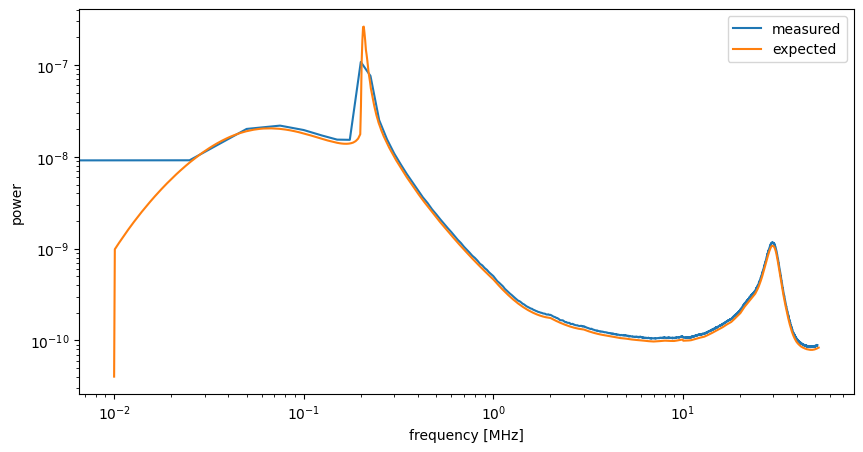

In [10]:
bits = 14
bit_level = 1/2**(bits-1)
generate_samples(P_adc, "adc_waveform", Nsec=2, bit_level=bit_level, bits=14)
fm, Pm = measure_pk("adc_waveform.bin")
make_plot(fm,Pm, f,P_adc, bit_level)

102400000.0 4096 1 50002 False False 10 True
*** Planning 204808192 samples = 2.00008 seconds. ***
*** Generating... ***
*** Seed: 10 ***
*** Transforming... ***
*** Done ***
min: -0.9139156937599182 max:0.9581137299537659 rms:0.11711698025465012  
sample min: -7487 sample max:7849  rms:959.4223022460938  
Read 204800000 records from adc_waveform_wPF.bin


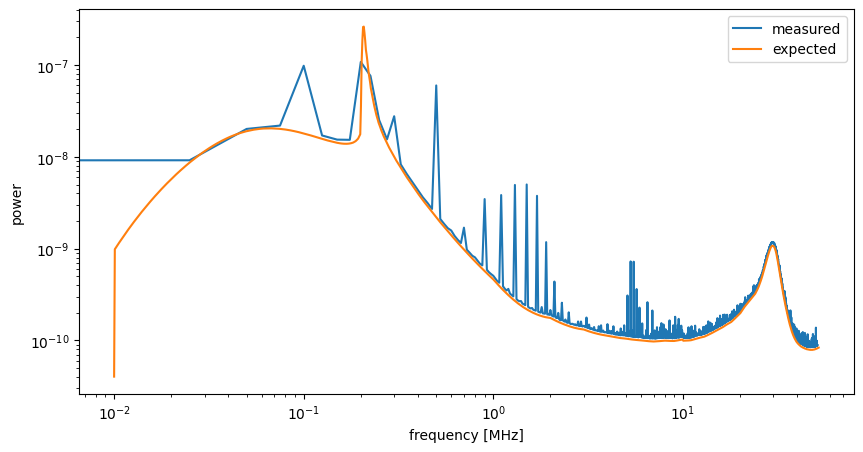

In [11]:
bits = 14
bit_level = 1/2**(bits-1)
generate_samples(P_adc, "adc_waveform_wPF", Nsec=2, bit_level=bit_level, bits=14, PF_amplitude=0.0006)
fm, Pm = measure_pk("adc_waveform_wPF.bin")
make_plot(fm,Pm, f,P_adc, bit_level)